In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from datasets import load_dataset

# Load the dataset by specifying its name
dataset = load_dataset("yh0701/FracAtlas_dataset", trust_remote_code = True)


In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']


In [5]:
print(train_dataset)
print(train_dataset[0])  # Print the first example

Dataset({
    features: ['image_id', 'image', 'hand', 'leg', 'hip', 'shoulder', 'mixed', 'hardware', 'multiscan', 'fractured', 'fracture_count', 'frontal', 'lateral', 'oblique', 'localization_metadata', 'segmentation_metadata'],
    num_rows: 2858
})
{'image_id': 'IMG0003480.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=373x454 at 0x1BBD2D02E80>, 'hand': 1, 'leg': 0, 'hip': 0, 'shoulder': 0, 'mixed': 0, 'hardware': 0, 'multiscan': 0, 'fractured': 0, 'fracture_count': 0, 'frontal': 0, 'lateral': 1, 'oblique': 0, 'localization_metadata': {'width': 373, 'height': 454, 'depth': 3}, 'segmentation_metadata': None}


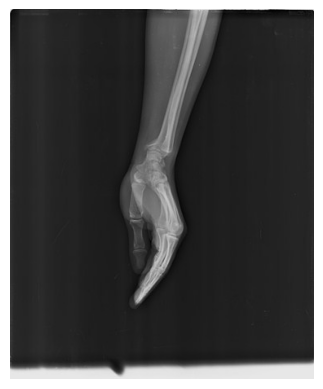

In [6]:
# Access the first image in the dataset
first_image = dataset['train'][0]['image']

import matplotlib.pyplot as plt

# Display the first image using matplotlib
plt.imshow(first_image)
plt.axis('off')  # Turn off axis labels
plt.show()


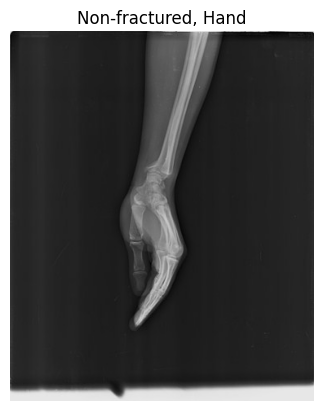

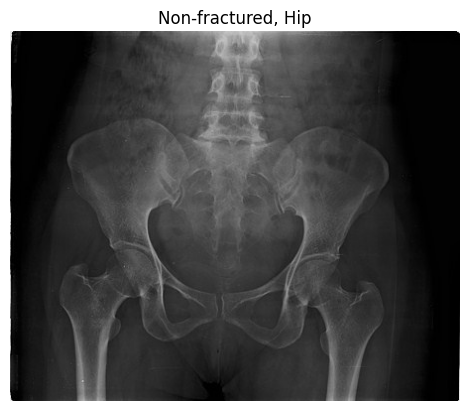

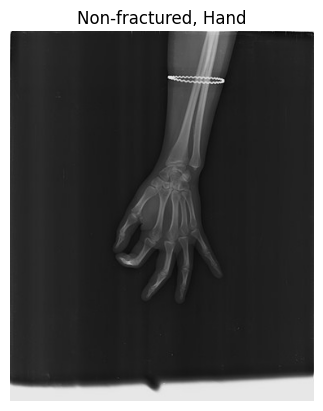

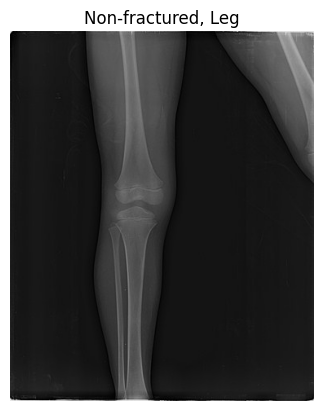

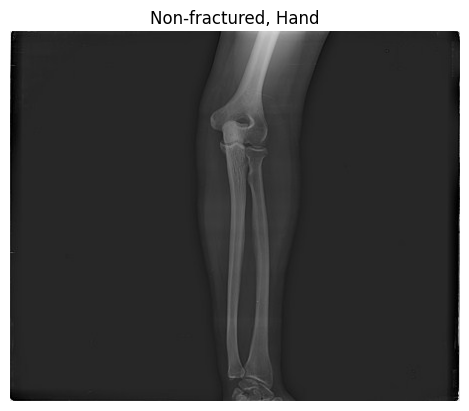

In [7]:
import matplotlib.pyplot as plt

# Function to display image with labels
def show_image_with_labels(image, labels):
    plt.imshow(image)
    plt.axis('off')
    plt.title(labels)
    plt.show()

# Display a few images with their labels
for i in range(5):
    image = dataset['train'][i]['image']
    # Creating a string of labels to display
    labels = []
    if dataset['train'][i]['fractured']:
        labels.append('Fractured')
    else:
        labels.append('Non-fractured')
    if dataset['train'][i]['hand']:
        labels.append('Hand')
    if dataset['train'][i]['leg']:
        labels.append('Leg')
    if dataset['train'][i]['hip']:
        labels.append('Hip')
    if dataset['train'][i]['shoulder']:
        labels.append('Shoulder')

    labels_text = ", ".join(labels)  # Combine labels into a single string
    show_image_with_labels(image, labels_text)


In [8]:
from torchvision import transforms

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Define transformations for training with data augmentation
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),    # Convert grayscale to RGB (3 channels)
    transforms.Resize((256, 256)),                   # Resize to a slightly larger size
    transforms.RandomResizedCrop(224),               # Randomly crop to 224x224
    transforms.RandomHorizontalFlip(),               # Random horizontal flip
    transforms.RandomRotation(15),                   # Random rotation by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Random brightness/contrast adjustment
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std) # Normalize using ImageNet stats
])


# Define transformations for validation and testing (without augmentation)
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),    # Convert grayscale to RGB (3 channels)
    transforms.Resize((224, 224)),                   # Resize directly to 224x224
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std) # Normalize using ImageNet stats
])


In [9]:
from PIL import Image, ImageFile
import io

# Enable loading of truncated images
def transform_dataset(example, transform):
    try:
        # Ensure example['image'] is a PIL Image object
        if isinstance(example['image'], bytes):
            image = Image.open(io.BytesIO(example['image'])).convert('RGB')
        else:
            image = example['image']
        
        # Apply the transformation
        example['image'] = transform(image)
    
    except (OSError, IOError, ValueError) as e:
        # Handle the error by logging the image name and skipping it
        print(f"Skipping invalid image {example.get('image_name', 'unknown')}: {e}")
        return None
    
    return example

# Apply transformations to the datasets
train_dataset = train_dataset.map(lambda x: transform_dataset(x, train_transforms))
val_dataset = val_dataset.map(lambda x: transform_dataset(x, val_test_transforms))
test_dataset = test_dataset.map(lambda x: transform_dataset(x, val_test_transforms))

# Filter out any None values (invalid images) after transformation
train_dataset = [example for example in train_dataset if example is not None]
val_dataset = [example for example in val_dataset if example is not None]
test_dataset = [example for example in test_dataset if example is not None]

Map:   0%|          | 0/2858 [00:00<?, ? examples/s]

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

Map:   0%|          | 0/613 [00:00<?, ? examples/s]

In [10]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create DataLoader for training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation dataset
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}


In [11]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim


model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
num_ftrs = model.classifier.in_features

# Define a new classifier
model.classifier = nn.Linear(num_ftrs, 2)

In [12]:
# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Only train the classifier parameters
for param in model.classifier.parameters():
    param.requires_grad = True


In [13]:
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
# Only parameters that require gradients are passed to the optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [49]:
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

data_dir = 'D:/downloads/fracatlas/FracAtlas/images'
batch_size = 32


In [54]:
from torchvision import transforms

# Define your transforms with augmentation for the training dataset
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),   # Random crop to 224x224 pixels
    transforms.RandomHorizontalFlip(),    # Random horizontal flip
    transforms.RandomRotation(20),        # Random rotation by up to 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.ToTensor(),                # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize
])

# Define transforms for validation and test datasets (usually without augmentation)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply the transforms
dataset = ImageFolder(root=data_dir, transform=val_transform)  # Apply to validation/test initially

# Split the dataset into train, val, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply augmentation to the train dataset
train_dataset.dataset.transform = train_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [55]:
# Check sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 2858
Validation dataset size: 612
Test dataset size: 613


In [52]:
for images, labels in train_loader:
    print(images.size(), labels.size())
    break

torch.Size([32, 3, 256, 256]) torch.Size([32])


ValueError: num must be an integer with 1 <= num <= 8, not 9

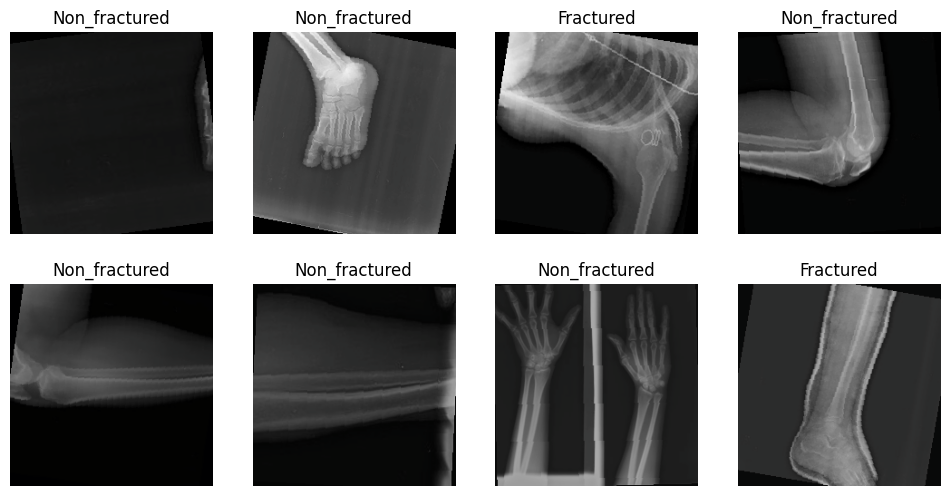

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T

def denormalize_image(tensor, mean, std):
    """ Denormalize the image tensor """
    mean = np.array(mean)
    std = np.array(std)
    tensor = tensor.numpy().transpose((1, 2, 0))
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

def show_batch(data_loader, mean, std, classes):
    """ Display a batch of images with their labels """
    images, labels = next(iter(data_loader))
    
    # Denormalize and convert to numpy
    images = [denormalize_image(img, mean, std) for img in images]
    
    # Set up plot
    plt.figure(figsize=(12, 6))
    
    # Plot images
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(2, 4, i + 1)  # Adjust subplot size according to your batch size
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')
    
    plt.show()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Assuming your dataset has `classes` attribute
classes = dataset.classes

show_batch(train_loader, mean, std, classes)

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers (e.g., layer4 and the classifier)
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Binary classification (1 output neuron)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_correct = 0
    
    # Progress bar for training
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for inputs, labels in train_loader_tqdm:
        # Move data to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate accuracy
        preds = torch.sigmoid(outputs).squeeze() > 0.5
        train_correct += torch.sum(preds == labels).item()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = train_correct / len(train_loader.dataset)
    print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.sigmoid(outputs).squeeze() > 0.5
            val_correct += torch.sum(preds == labels).item()
    
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Save the model
torch.save(model.state_dict(), 'resnet50_fracture_classifier.pth')


C:\Users\moham\.conda\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moham\.conda\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 90/90 [01:20<00:00,  1.12batch/s]


Training Loss: 0.4212, Training Accuracy: 0.8202
Validation Loss: 0.4076, Validation Accuracy: 0.8448


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 90/90 [01:04<00:00,  1.38batch/s]


Training Loss: 0.3609, Training Accuracy: 0.8555
Validation Loss: 0.4326, Validation Accuracy: 0.8023


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 90/90 [01:04<00:00,  1.40batch/s]


Training Loss: 0.3467, Training Accuracy: 0.8646
Validation Loss: 0.3786, Validation Accuracy: 0.8399


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 90/90 [01:04<00:00,  1.39batch/s]


Training Loss: 0.3501, Training Accuracy: 0.8625
Validation Loss: 0.3721, Validation Accuracy: 0.8431


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 90/90 [01:07<00:00,  1.34batch/s]


Training Loss: 0.3328, Training Accuracy: 0.8667
Validation Loss: 0.3921, Validation Accuracy: 0.8497


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 90/90 [01:08<00:00,  1.32batch/s]


Training Loss: 0.3232, Training Accuracy: 0.8723
Validation Loss: 0.3596, Validation Accuracy: 0.8529


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 90/90 [01:07<00:00,  1.32batch/s]


Training Loss: 0.3077, Training Accuracy: 0.8842
Validation Loss: 0.3599, Validation Accuracy: 0.8611


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 90/90 [01:08<00:00,  1.32batch/s]


Training Loss: 0.3265, Training Accuracy: 0.8642
Validation Loss: 0.3533, Validation Accuracy: 0.8693


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 90/90 [01:09<00:00,  1.29batch/s]


Training Loss: 0.3120, Training Accuracy: 0.8758
Validation Loss: 0.3648, Validation Accuracy: 0.8676


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 90/90 [01:06<00:00,  1.34batch/s]


Training Loss: 0.3136, Training Accuracy: 0.8768
Validation Loss: 0.3612, Validation Accuracy: 0.8513


Test Loss: 0.3492, Test Accuracy: 0.8630


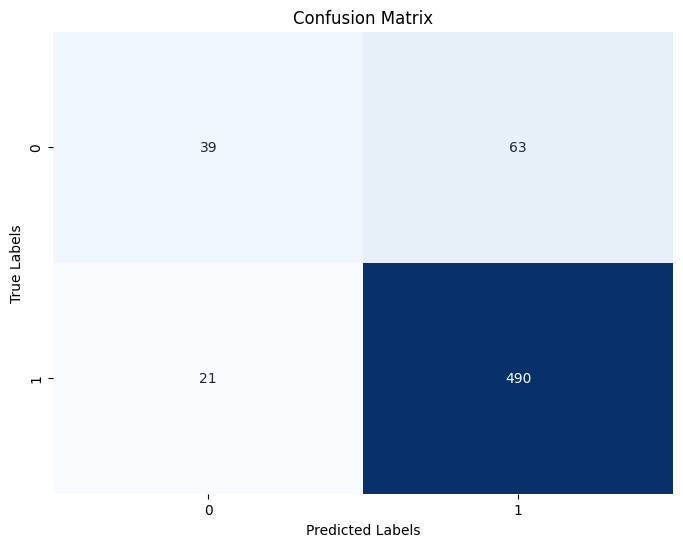

Precision: 0.8861
Recall: 0.9589
F1 Score: 0.9211


In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Testing phase
model.eval()
test_loss = 0.0
test_correct = 0

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        
        test_loss += loss.item() * inputs.size(0)
        
        preds = torch.sigmoid(outputs).squeeze() > 0.5
        test_correct += torch.sum(preds == labels).item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_acc = test_correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Compute precision, recall, and F1 score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [74]:
from collections import Counter

# Function to check label distribution
def check_label_distribution(dataset, dataset_name):
    labels = [dataset.dataset.targets[i] for i in dataset.indices]
    label_count = Counter(labels)
    total_samples = sum(label_count.values())
    
    print(f"Label distribution in {dataset_name} dataset:")
    for label, count in label_count.items():
        percentage = 100 * count / total_samples
        print(f"Class {label}: {count} samples ({percentage:.2f}%)")
    print("-" * 40)

# Check label distribution for each dataset
check_label_distribution(train_dataset, "Train")
check_label_distribution(val_dataset, "Validation")
check_label_distribution(test_dataset, "Test")

Label distribution in Train dataset:
Class 1: 2360 samples (82.58%)
Class 0: 498 samples (17.42%)
----------------------------------------
Label distribution in Validation dataset:
Class 1: 495 samples (80.88%)
Class 0: 117 samples (19.12%)
----------------------------------------
Label distribution in Test dataset:
Class 1: 511 samples (83.36%)
Class 0: 102 samples (16.64%)
----------------------------------------
